# Das "Obstsalat"-Modell verbessern

Wir wollen sehen, ob wir das "Obsalat" Modell verbessern können.



In [ ]:
!pip install -Uqq fastai duckduckgo_search
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.6 MB/s eta 0:00:00


## Step 1: Laden des Modells und der Daten

Das Obsalat Modell laden

Die Obstbilder laden

In [ ]:
!git clone -n https://github.com/dnhshl/cc-ai --depth 1
!git -C cc-ai  checkout HEAD data/fruits.zip
!unzip cc-ai/data/fruits.zip -d .

!git -C cc-ai  checkout HEAD models/obsalatV1.pkl

learn = load_learner('cc-ai/models/obsalatV1.pkl')

Cloning into 'cc-ai'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 1), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), 61.38 MiB | 8.97 MiB/s, done.
Updated 1 path from f55e9d4
unzip:  cannot find or open data/fruits.zip, data/fruits.zip.zip or data/fruits.zip.ZIP.
Updated 1 path from f55e9d4


NameError: ignored

In [ ]:
learn.predict('/content/fruits/apple/0416ea96-4b1c-4a34-9a07-f12d5d23de45.jpg')


('apple', TensorBase(0), TensorBase([9.9812e-01, 1.6430e-03, 2.3461e-04]))

## Step 2: Güte des Modells prüfen

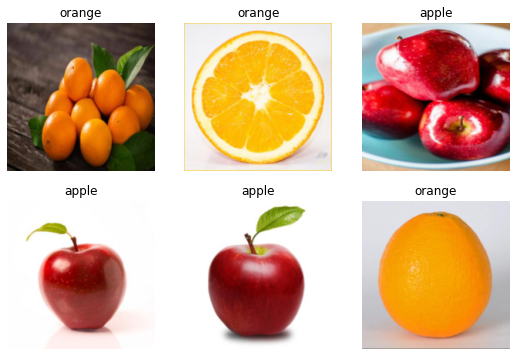

In [ ]:
path = Path('fruits')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

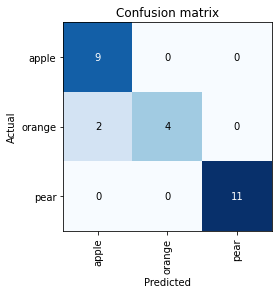

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

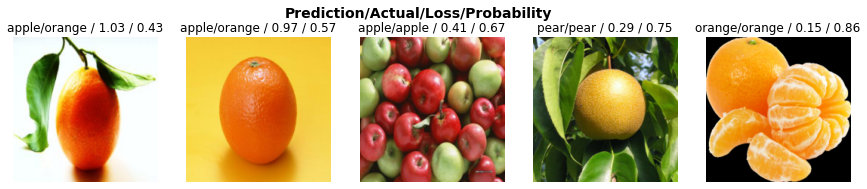

In [18]:
interp.plot_top_losses(5, nrows=1)

In [21]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

## Data Augmentation

### From Data to DataLoaders
jargon: DataLoaders: A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties.

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

  - What kinds of data we are working with
  - How to get the list of items
  - How to label these items
  - How to create the validation set
  
So far we have seen a number of factory methods for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the data block API. With this API you can fully customize every stage of the creation of your DataLoaders. Here is what we need to create a DataLoaders for the dataset that we just downloaded:

In [22]:
fruits = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [23]:
dls = fruits.dataloaders(path)

A DataLoaders includes a validation and a training DataLoader. DataLoader is a class that provides batches of a few items at a time to the GPU. When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the show_batch method on a DataLoader:

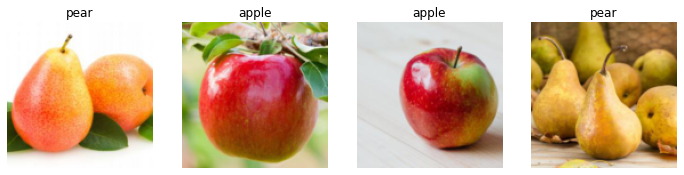

In [24]:
dls.valid.show_batch(max_n=4, nrows=1)

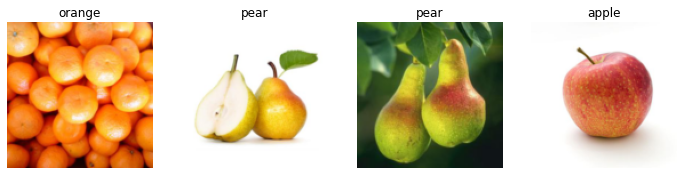

In [25]:
dls.train.show_batch(max_n=4, nrows=1)

By default **Resize** crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

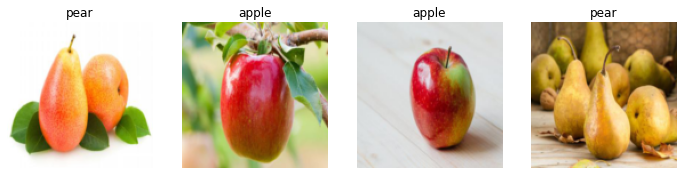

In [26]:
fruits = fruits.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

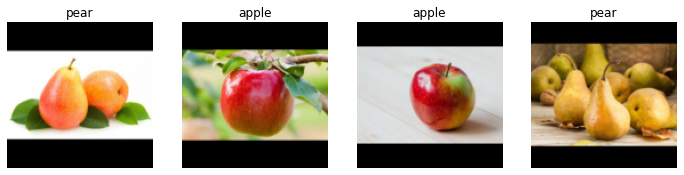

In [27]:
fruits = fruits.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is min_scale, which determines how much of the image to select at minimum each time:

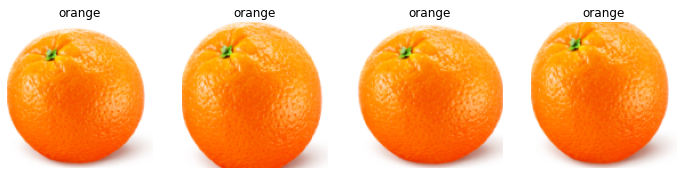

In [36]:
fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.8))
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

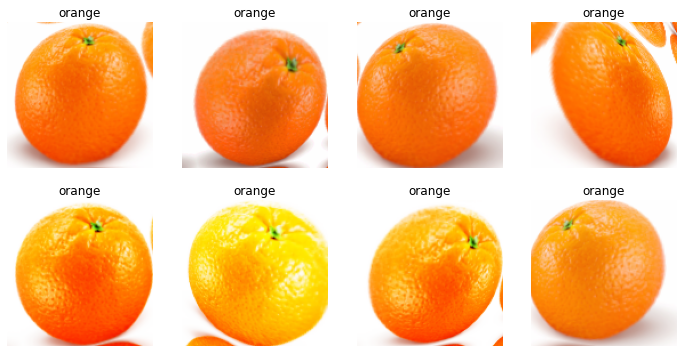

In [38]:
fruits = fruits.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [39]:
fruits = fruits.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = fruits.dataloaders(path)
     

In [40]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


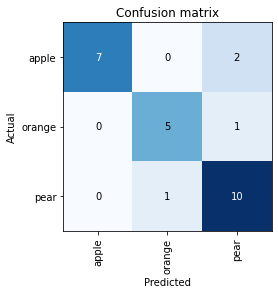

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [42]:
learn.export('obstsalatV2.pkl')